In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import imputation

from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt

from joblib import Parallel, delayed
import multiprocessing

from time import time
import seaborn as sns

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist

In [2]:
partition_data = False

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time()
        result = method(*args, **kw)
        te = time()

        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result

    return timed

def _qn(x, agg='mean'):    
    if agg=='mean':
        @jit
        def _agg(x):
            return np.nanmean(x)
    elif agg=='median':
        @jit
        def _agg(x):
            return np.nanmedian(x)
    @jit
    def __qn(x):
        # assumes column-wise normalisation
        x_sorted = np.empty(x.shape, dtype='float32')
        x_arg_sorted = np.empty(x.shape, dtype='int64')
        x_agg = np.empty(x.shape, dtype='float32')
        x_res = np.empty(x.shape, dtype='float32')

        #print('Sorting probe vectors..')
        for j in range(0, x.shape[1]):
            x_sorted[:,j] = np.sort(x[:, j])
            x_arg_sorted[:,j] = np.argsort(x[:, j])
        #print('Extract agg values per rank..')
        for i in range(0, x.shape[0]):
            x_agg[i,:] = _agg(x_sorted[i,:])
        #print('attach agg values to original rank vectors and unsort')
        for j in range(0, x.shape[1]):
            iv = x_arg_sorted[:,j].astype(int)
            x_res[:,j] = x_agg[:,j][iv]
        return x_res
    
    res = __qn(x)
    return res


In [4]:
def _clean(x, default='float'):   
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in x.columns:
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

from sklearn.ensemble import IsolationForest
def _remove_outliers(x, method='isoforest'):
    '''
    x: pandas data frame or numpy array
    method: isoforest 
    '''
    if method=='isoforest': 
        # isolation forest       
        model = IsolationForest(n_estimators=100,)
    
    # consider Angle Based Outlier Detection
    # consider using sample aggregate of z-scores
    return x
    
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence
    
    return True

def _dimension_reduction(x, method='PCA', dimension=3):
    # method: PCA, SAE, UMAP

    return True   
    
                     
def _outliers_modified_z_score(ys, threshold = 3.5):
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return modified_z_scores, np.where(np.abs(modified_z_scores) > threshold)
    

In [5]:
# L/S parallelised
@timeit
def _preprocess_par(df, cohorts = [], 
                scaler = "standard", 
                bias_removal = False, 
                col_range = None, 
                min_cohort_size=10, 
                qrange=(0.25,0.75),
                debug=False,
                n_jobs=10,
                imputer=None):
        
        def _norm(cohort, partition=None):
            ch = df[partition]==cohort
            if sum(ch)<min_cohort_size:
                print("Skipping cohort {}, because of low sample count: {}".format(cohort, sum(ch)))
            else:
                if debug==False:
                    try:
                        if imputer is not None:                                
                            imp = imputation.Imputer(strategy=imputer, axis=0)
                            res = scaler.fit_transform(imp.fit_transform(df.loc[ch,gene_columns].values))
                        else:
                            res = scaler.fit_transform(df.loc[ch,gene_columns].values)
                        df.loc[ch,gene_columns] = pd.DataFrame(data=res, index=ch[ch].index, columns=gene_columns)
                        print("Corrected cohort {}, with {} samples".format(cohort, sum(ch))) 
                    except Exception as e:
                        print("ERROR", e, "cohort:"+cohort)
                        print("index:",ch)
                        print("target:", df.loc[ch,gene_columns].shape) 
                        print("replacement:", res.shape)
                else:
                    for _col in gene_columns: # for debugging
                        df_temp = df.loc[ch, _col].copy() 
                        try:
                            df.loc[ch, _col] = (df_temp-df_temp.mean())/df_temp.std()
                        except Exception as e:
                            print("ERROR", e, "gene:"+_col, "cohort:"+cohort)
            return df[ch]
        def _quantile(cohort, partition=None):
                ch = df[partition]==cohort
                tor = df.loc[ch, gene_columns]
                t = tor.T
                tqn = _qn(t.values)
                df[gene_columns][ch] = tqn.T # pd.DataFrame(data=tqn.T, index=tor.index, columns=gene_columns)
                return df[ch]
    
        if col_range is None:
            gene_columns = [_col for _col in df.columns if 'GenX' in _col]  
        else:                      
            cr = range(col_range[0], col_range[1])
            gene_columns = df.columns[cr]
        
        if len(cohorts)==0:
            cohorts = df.batch_number.unique().tolist()
        
        if scaler == "standard":
            scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        elif scaler == "minmax":
            scaler = preprocessing.MinMaxScaler()
        elif scaler == "maxabs":
            scaler = preprocessing.MaxAbsScaler()
        elif scaler == "robust":
            scaler = preprocessing.RobustScaler(quantile_range=qrange, 
                                                    with_scaling=True, with_centering=True)
        elif scaler in ["normalizer", "normaliser"]:
            scaler = preprocessing.Normalizer()  
            
        if bias_removal == True:  
            print("- "*30, 'Removing cohort biases')    
            if scaler != 'quantile':           
                results = Parallel(n_jobs=n_jobs)(delayed(_norm)(cohort) for cohort in cohorts)
            else:
                results = Parallel(n_jobs=n_jobs)(delayed(_quantile)(cohort) for cohort in cohorts)
                
            print("- "*30, 'Concatenating results')    
            df = pd.concat(results)
            
        else:
            ch = df[partition].isin(cohorts)
            df.loc[ch,gene_columns] = scaler.fit_transform(df.loc[ch,gene_columns])
            
        #df = df[df.batch_number.isin(cohorts)]
        return df  
    

In [6]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['sample_id'] = pheno_large.index
pheno_large['gender.demographic'] = pheno_large['gender.demographic'].apply(lambda x: 0 
                                                                            if x=='male' else 1 
                                                                                if pd.isna(x)==False 
                                                                                else np.nan)
pheno_large = pheno_large.merge(pd.DataFrame(pheno_large.groupby(by='batch_number').size(), 
                              columns=['batch_size']),
                  left_on='batch_number', right_on='batch_number')

pheno_large = pheno_large.merge(
    pd.DataFrame(pheno_large.groupby(by='batch_number')['gender.demographic']\
                     .mean().reset_index().rename(index=str, columns={'gender.demographic':'gender_mean'})),
                  how='left', left_on='batch_number', right_on='batch_number')

In [7]:
root_dir = '/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung'
type_data = pd.read_csv(root_dir+'/HumanMethylation450_meta.csv', engine='c', sep=',',header=7)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
type_data.columns

Index(['IlmnID', 'Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID',
       'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base',
       'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO',
       'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs',
       'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name',
       'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer',
       'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group',
       'DHS'],
      dtype='object')

In [9]:
type_data['RefGene'] = type_data.UCSC_RefGene_Group.str.split(';').apply(lambda x: 
                                                                         ",".join(sorted(set(x))) 
                                                                         if type(x)==list else np.nan)
rare_refgene = type_data.RefGene.value_counts().index[type_data.RefGene.value_counts()<100].tolist()
type_data['RefGene'][type_data.RefGene.isin(rare_refgene)] = 'uncommon' 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [10]:
type_data = type_data[['IlmnID', 'Name', 'Infinium_Design_Type', 
                       'Color_Channel', 'Relation_to_UCSC_CpG_Island', 'CHR', 'RefGene']]

In [11]:
gc.collect()
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2" # "/media/bramvanes/Extra/DATA/RexR/2018" #  #"/media/bramvanes/Extra/DATA/RexR/2018" #
methylation = pd.read_table(sourceDir+"/Lung/Lung_Methylation.txt", sep="\t")

In [12]:
methylation= methylation.copy().merge(type_data[['IlmnID',
                                                 'Infinium_Design_Type', 
                                                 'Color_Channel', 
                                                 'Relation_to_UCSC_CpG_Island',
                                                 'CHR',
                                                 'RefGene']], 
                                      how='left', left_on='probeID', right_on='IlmnID')

In [13]:
pat_cols = [_col for _col in methylation.columns if 'TCGA-' in _col] 

In [80]:
num_samples = 25
_cols = ['probeID'] + pat_cols[:num_samples]
boxplot_data = pd.melt(methylation.loc[:,_cols], id_vars='probeID', value_vars = pat_cols[:num_samples], var_name='probe_values')

In [106]:
boxplot_data = boxplot_data.copy().merge(pheno_large[['batch_number', 'sample_id']], 
                                         how='left', 
                                         left_on='probe_values', 
                                         right_on='sample_id').drop('sample_id', axis=1)

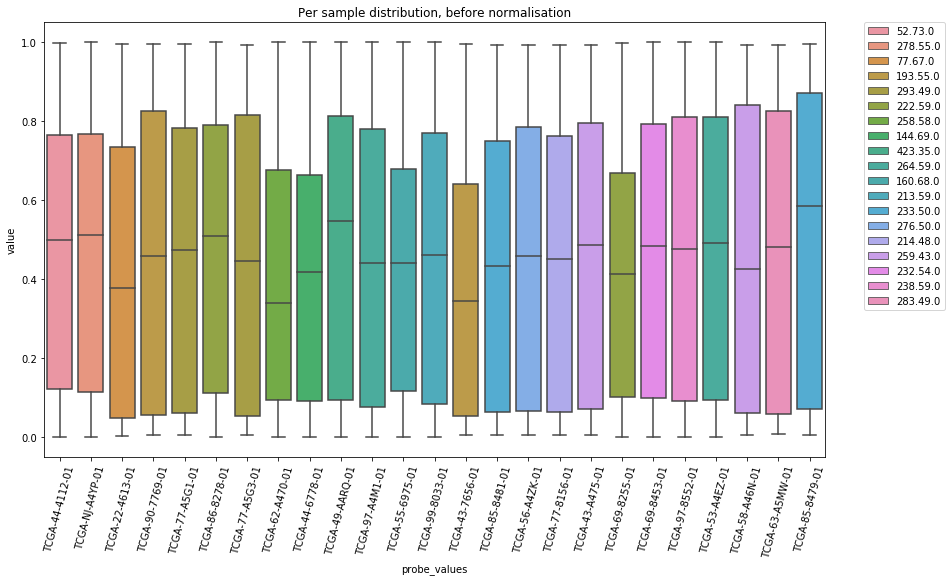

In [117]:
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='probe_values', y='value', data=boxplot_data, hue='batch_number', dodge=False,  ax=ax) # , probe_values
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set_title('Per sample distribution, before normalisation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [101]:
methylation_Transpose = methylation.loc[:, pat_cols].T
methylation_Transpose.columns = methylation.probeID

In [90]:
methylation_Transpose.dropna(axis=1, thresh=100, inplace=True)
methylation_Transpose = methylation_Transpose.copy().merge(pheno_large[['batch_number', 'sample_id']], 
                            how='inner',
                            left_index=True, 
                            right_on='sample_id').drop('sample_id', axis=1)

In [ ]:
batches  = methylation_Transpose.batch_number.unique().tolist()
prob_cols = [_col for _col in methylation_Transpose.columns if 'batch' not in _col] 

In [151]:
methylation_Transpose_by_batch = methylation_Transpose.copy().groupby('batch_number').mean().T
methylation_Transpose_by_batch['probe'] = methylation_Transpose_by_batch.index

In [205]:
num_batches = 38
_cols = ['probe'] + batches[:num_batches]
boxplot_data = pd.melt(methylation_Transpose_by_batch.loc[:,_cols], 
                       id_vars='probe', value_vars = batches[:num_batches], var_name='batch_number')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [195]:
df1 = pheno_large.groupby('batch_number')['number_pack_years_smoked'].agg(['mean', 'count'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'smoke_years',
                                                                                             'count': 'batch_size'})

df2 = pheno_large.groupby('batch_number')['cigarettes_per_day.exposures'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'cigs_per_days'})

df3 = pheno_large.groupby('batch_number')['age_at_initial_pathologic_diagnosis'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'age'})

df4 = pheno_large.groupby('batch_number')['gender.demographic'].agg(['mean'])\
                                                    .reset_index().rename(index=str,columns={'mean': 'gender'})

In [202]:
dff = df1.merge(df2, how='inner', left_on='batch_number', right_on='batch_number')
dff = dff.copy().merge(df3, how='inner', left_on='batch_number', right_on='batch_number')
dff = dff.copy().merge(df4, how='inner', left_on='batch_number', right_on='batch_number')

In [207]:
boxplot_data = boxplot_data.copy().merge(dff, how='inner', left_on='batch_number', right_on='batch_number')

In [231]:
_tmp = boxplot_data.groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val',
                                                                                                  'median': 'median_val'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

5872

In [248]:
_tmp = boxplot_data[boxplot_data.value>=0.5].groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val_up',
                                                                                                  'median': 'median_val_up'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

_tmp = boxplot_data[boxplot_data.value<0.5].groupby(by='batch_number').value.agg(['mean', 'median']).reset_index().rename(index=str, 
                                                                                          columns={'mean':'mean_val_down',
                                                                                                  'median': 'median_val_down'})
boxplot_data = boxplot_data.copy().merge(_tmp, how='inner', left_on='batch_number', right_on='batch_number')
del _tmp
gc.collect()

63

Text(0.5,1,'Per cohort distribution of mean probe values, before normalisation')

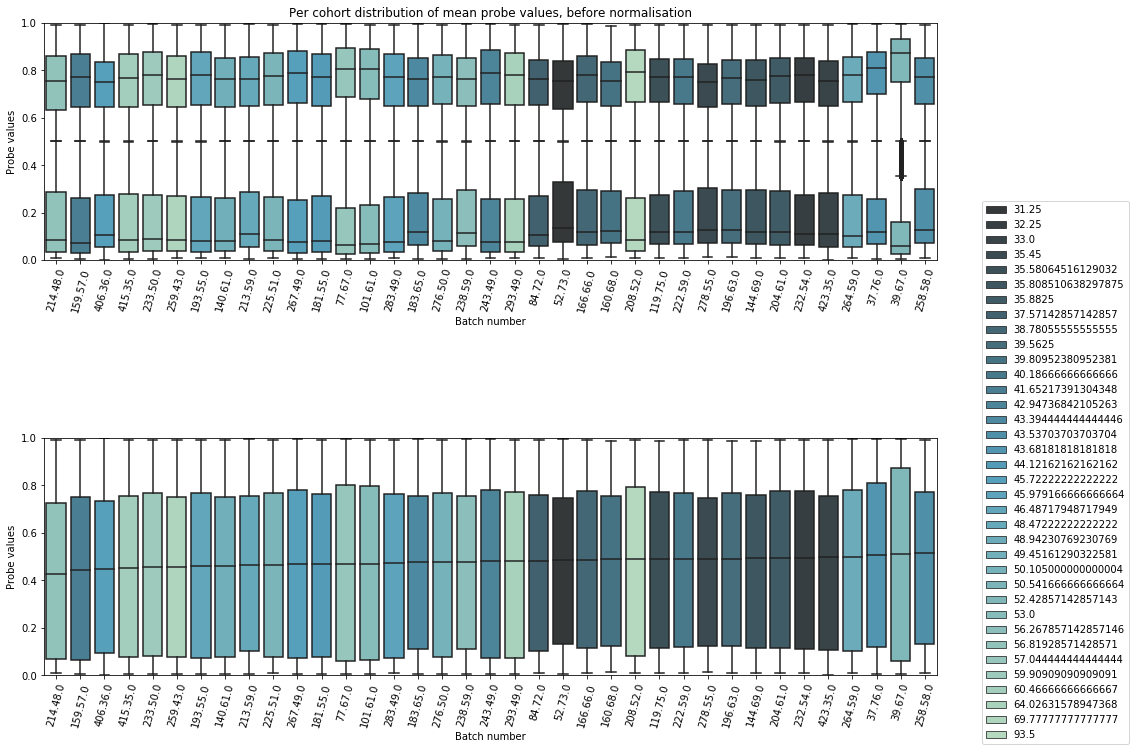

In [267]:
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
phenotype = 'smoke_years'

boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data.loc[boxplot_data.value>=0.5],
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
#
boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data.loc[boxplot_data.value<0.5],
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=75)
ax[0].get_legend().remove()
ax[0].set_xlabel('Batch number')
ax[0].set_ylabel('Probe values')
ax[0].set_ylim(0,1)
#
boxplot_data.sort_values(by='median_val', inplace=True)
sns.boxplot(x='batch_number', 
            y='value',
            data=boxplot_data,
            dodge=False, 
            hue=phenotype, 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[1]) # , probe_values
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75)
ax[1].legend(bbox_to_anchor=(1.05, 2), loc=2, borderaxespad=0.)
ax[1].set_xlabel('Batch number')
ax[1].set_ylabel('Probe values')
ax[1].set_ylim(0,1)

fig.subplots_adjust(hspace=0.75)
ax[0].set_title('Per cohort distribution of mean probe values, before normalisation')


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


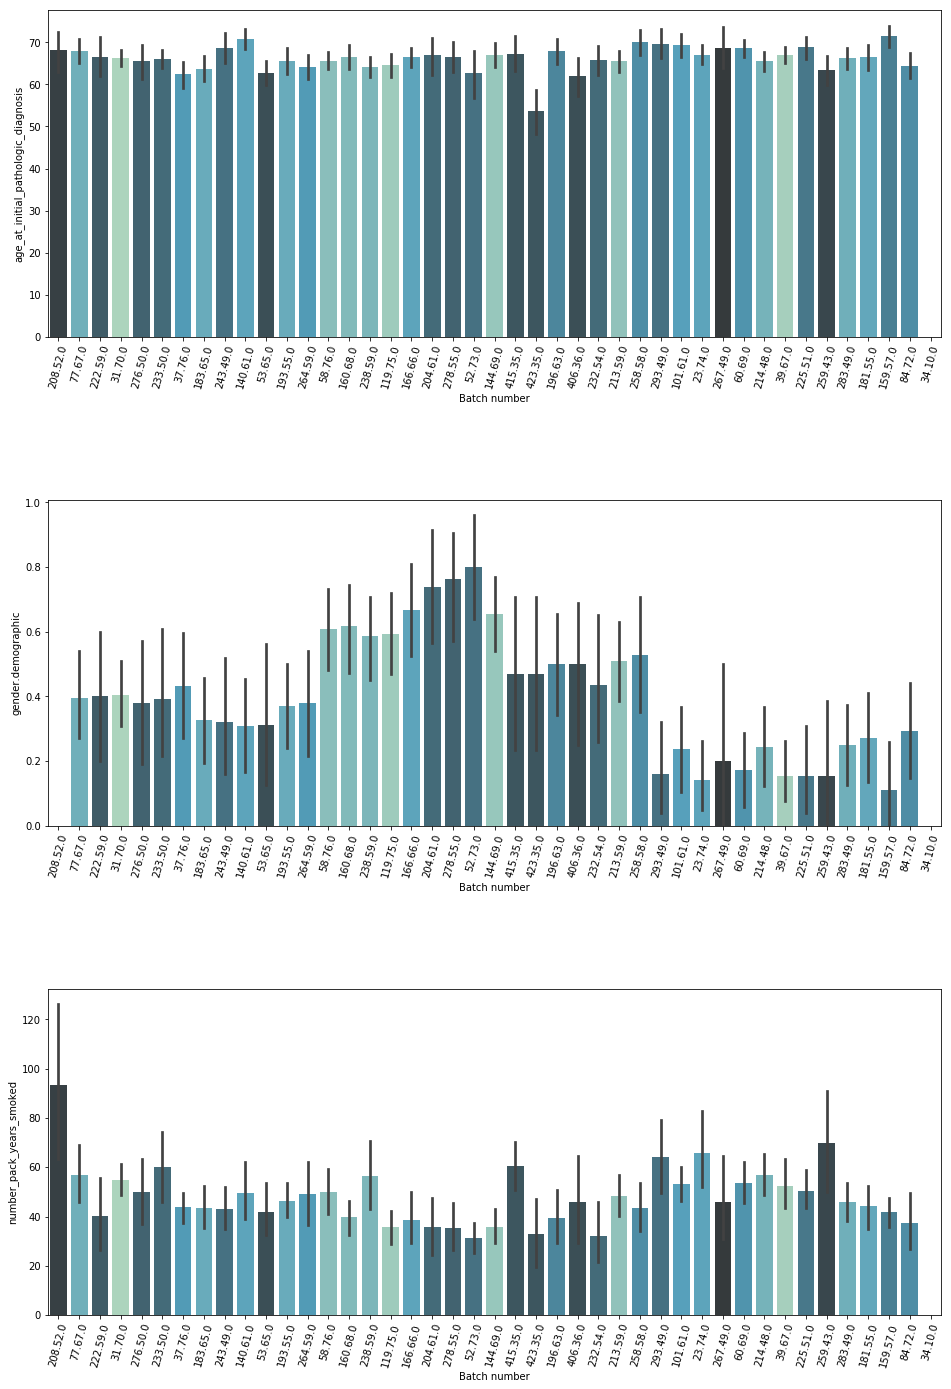

In [499]:
# plot's of phenotypical values over cohorts
fig, ax = plt.subplots(nrows=3, figsize=(16,24))
phenotypes = ['age_at_initial_pathologic_diagnosis', 
              'gender.demographic', # gender_mean
              'number_pack_years_smoked', 
              'cigarettes_per_day.exposures']

pheno_large.sort_values(by=phenotypes[1], inplace=True)

sns.barplot(x='batch_number', 
            y=phenotypes[0],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[0]) # , probe_values
#
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=75)
ax[0].get_legend().remove()
ax[0].set_xlabel('Batch number')
ax[0].set_ylabel(phenotypes[0])
#
sns.barplot(x='batch_number', 
            y=phenotypes[1],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[1]) # , probe_values
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75)
ax[1].get_legend().remove()
ax[1].set_xlabel('Batch number')
ax[1].set_ylabel(phenotypes[1])
#
sns.barplot(x='batch_number', 
            y=phenotypes[2],
            data=pheno_large,
            dodge=False, 
            hue='batch_size', 
            palette="GnBu_d", # Blues, sns.cubehelix_palette(8)
            ax=ax[2]) # , probe_values
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=75)
ax[2].get_legend().remove()
ax[2].set_xlabel('Batch number')
ax[2].set_ylabel(phenotypes[2])
#

fig.subplots_adjust(hspace=0.5)
#ax[0].set_title('Per cohort distribution of mean probe values, before normalisation')

In [500]:
# significances of differences between pheno's.
tot_res = []
for _phenotype in phenotypes:    
    res = []
    for _batch_nr in batches:
        _all = pheno_large.loc[pheno_large.batch_number!=_batch_nr][_phenotype]
        _batch = pheno_large.loc[pheno_large.batch_number==_batch_nr][_phenotype]
        _ks = ks2(_all.values, _batch.values)
        _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
        try:
            _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
        except ValueError as e:
            print('ValError, defaulting to NaN')
            _w1 = _w2 = np.nan
        
        res.append({'batch_number': _batch_nr,
                    'ks_stat': _ks[0], 'ks_p': _ks[1],
                    'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                    'w1_dist': _w1, 'w2_dist': _w2})
    res_df = pd.DataFrame(res)
    tot_res.append(res_df)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4775: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / (1.0*n2)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4780: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


ValError, defaulting to NaN
ValError, defaulting to NaN
ValError, defaulting to NaN
ValError, defaulting to NaN


p=0.01->4 cohorts, p=0.05->13 cohorts


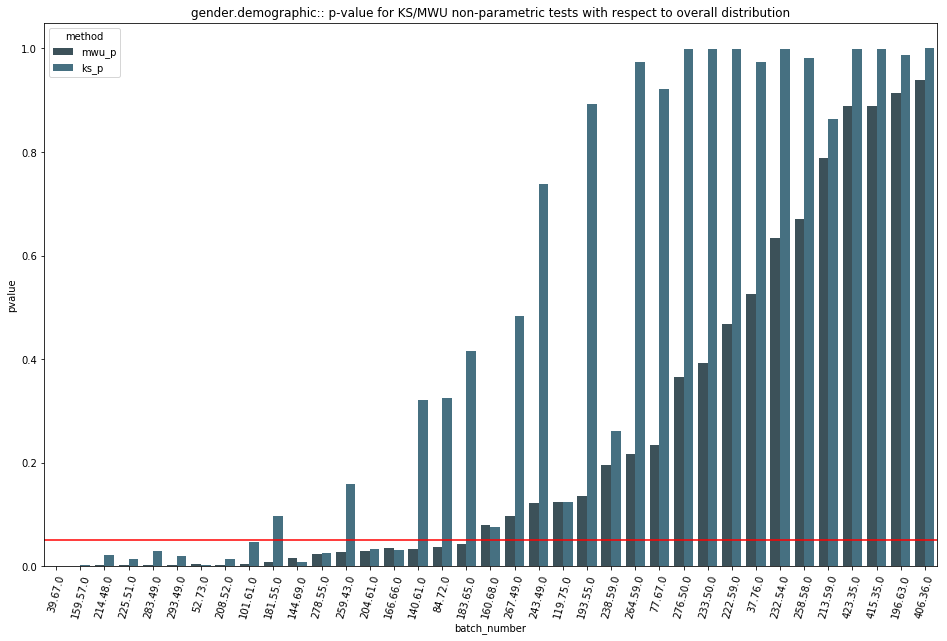

In [502]:
fig, ax = plt.subplots(figsize=(16,10))
idx = 1
barplot_data = pd.melt(tot_res[idx][['batch_number', 'ks_p', 'mwu_p']],
                       id_vars='batch_number',
                       value_vars=['ks_p', 'mwu_p'],
                       value_name='pvalue',
                       var_name='method')
barplot_data.sort_values(by='pvalue', inplace=True)
sns.barplot(x='batch_number', y='pvalue', hue='method', data=barplot_data, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.axhline(0.05, color='red')
ax.set_title("{}:: p-value for KS/MWU non-parametric tests with respect to overall distribution".format(phenotypes[idx]))

print("p=0.01->{} cohorts, p=0.05->{} cohorts".format((tot_res[idx]['ks_p']<0.01).sum(), 
                                                      (tot_res[idx]['ks_p']<0.05).sum()))


Looking at the p-values for the Kolmogorov-Smirnof and Mann-Whitney U tests we find that most of the cohorts are not significantly different from the bulk distribution for age and number of smokes cigarettes. 

In [ ]:
# The inter-cohort distribution of mean/median

Before we even embark on the removal of cohort bias we should wonder whether the inter-cohort differences are not explainable with the phenotypical differences between the cohorts.

It seems that the age, gender and number of smoked cigarettes varies strongly between the different cohorts.
On the one hand this discourages the use of cohort bias correction as we might falsely remove variance, in the sense
that instead of reducing bias we simply remove signal. On the other hand, given that phenotypical differences differ significantly between the cohorts we might amplify or weaken these difference due to actual cohort measurement biases. Another question is, given the high variance of phenotypical values, can we even identify cohort biases?

We could look at the biological groups (age, gender, clinical history, etc.) and use their probe distributions as 
the reference distributions perhaps? The same for the sample types (normal, tumor, solid), site Of resection, tumor location etc. and the group each specific probe belongs to (type I/II, color).

The ComBat (implemented in R) method takes the covariates into account, as do the RUV methods (m, inverse) and the SubsetQN/SmoothedQN methods.

A note with ComBat: it only only takes categorical covariates into account. Hence, to apply ComBat to
numerical covariates we need to apply binning. 

As the covariates for the cohort bias correction we take:
* Years exposed to smoke
* Age
* Gender
* Tissue source site
* Sample type

In [106]:
_covariates = ['age_at_initial_pathologic_diagnosis',
                'years_smoked.exposures',
                'number_pack_years_smoked',
                'gender.demographic',
                'tissue_source_site',
                'sample_type.samples']

methylation_meta = pheno_large[['sample_id', 
                                'batch_number'
                                ]+_covariates]
methylation_meta.rename(index=str, columns={'batch_number': 'Batch',
                                            'sample_id': 'Sample name'}, inplace=True)
# create bins 
base_term = 'smoke_exposure_years'
_bins = 5
name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
methylation_meta.loc[:, 'cat_smoke_years'] = pd.qcut(methylation_meta['years_smoked.exposures'], q=_bins, labels=name_list)
methylation_meta.loc[:, 'cat_smoke_years'] = methylation_meta['cat_smoke_years'].cat.add_categories('Unknown').fillna('Unknown')

base_term = 'age'
_bins = 5
name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
methylation_meta.loc[:, 'cat_age'] = pd.qcut(methylation_meta['age_at_initial_pathologic_diagnosis'], q=_bins, labels=name_list)
methylation_meta.loc[:,'cat_age'] = methylation_meta['cat_age'].cat.add_categories('Unknown').fillna('Unknown')

base_term = 'number_of_packs'
_bins = 5
name_list = [base_term+"_"+str(i) for i in range(0,_bins)]
methylation_meta.loc[:,'cat_packs'] = pd.qcut(methylation_meta['number_pack_years_smoked'], q=_bins, labels=name_list)
methylation_meta.loc[:,'cat_packs'] = methylation_meta['cat_packs'].cat.add_categories('Unknown').fillna('Unknown')

methylation_meta.loc[:,'cat_gender'] = methylation_meta['gender.demographic'].astype('category')

methylation_meta.loc[:,'cat_source_site'] = methylation_meta['tissue_source_site'].astype('category')

methylation_meta.loc[:,'cat_sample_type'] = methylation_meta['sample_type.samples'].astype('category')

methylation_meta.drop(_covariates, axis=1, inplace=True)

methylation_meta['Array name'] = methylation_meta['Sample name']

methylation_meta.set_index('Array name', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [ ]:
methylation_Transpose.loc[:,prob_cols].to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/methylation_transposed.csv",
                            index=True, header=False, sep="\t")

methylation_meta.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/methylation_combat_meta_small.csv",
                            index=True, header=True, sep="\t")

In [ ]:
gc.collect()

ComBat allows for the inclusion of probe-specific categories such as CpG island, strand, color or type but we have not tried this.

In [ ]:
#M-value scale,  relative log expression (RLE), deviation from median expression level before normalisation, 
# per sample, colored by cohort. M = log2(beta/(beta-1))

# Normalisation per cohort

Before we quantile normalise over the *probe groups* (i.e. probe wise/column wise) we should 
remove any batch effects over the *patient groups* (i.e. patient wise per probe/row wise). 

For the methylation data we can apply
* quantile normalisation over the cohorts
* ComBat (Empirical Bayes)

A more recent method called RUV-2/RUV-inverse could not be applied because we do not have the negative control probes available. Arguably we can apply RUV(-2)/RUV-inverse using the Type I probe values as is done with Subset QN but we consider this out of scope for this paper.

Following this step we apply a probewise normalisation
* Global QN 
* Global QN per Type
* Subset Quantile normalisation per Type

# Cohort bias correction using L/S normalisation

In [13]:
affx_labels = list(methylation.set_index('Gene').filter(axis=0, regex=r"^(AFFX.*)").index) # AFFX 
methylation = methylation.drop(affx_labels, axis=0)

methylation.Start = pd.to_numeric(methylation.Start)
methylation.Stop = pd.to_numeric(methylation.Stop)

methylation = methylation[np.isfinite(methylation.Start)]
methylation = methylation[np.isfinite(methylation.Stop)]

methylation.Start = methylation.Start.astype(int).astype(str)
methylation.Stop = methylation.Stop.astype(int).astype(str)
methylation.Chr = methylation.Chr.astype(str)
methylation.Gene = methylation.Gene.astype(str)


if partition_data == True:
    methylation['GenX'] = methylation[['Gene', 'Chr', 'Start', 'Stop']].apply(lambda x: '.'.join(x), axis=1)
    _map_RNA = methylation[['Gene', 'Chr', 'Start', 'Stop', 'Strand', 'GenX']]
    methylation = methylation.drop(['Gene', 'Chr', 'Start', 'Stop'], axis=1)
    methylation.dropna(thresh=10, axis=0, inplace=True)

    # remove duplicate GenX values
    methylation = methylation.copy().loc[~methylation.GenX.duplicated(keep='first')]
    methylation.set_index('probeID', inplace=True)
    
    dict_methylation={'Methylation_Strand_plus_CpG_Island': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island=='Island')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_plus_CpG_Nshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island=='N_Shelf')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_plus_CpG_Nshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island=='N_Shore')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                  
                      'Methylation_Strand_plus_CpG_Sshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island=='S_Shelf')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_plus_CpG_Sshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island=='S_Shore')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_plus_CpG_NaN': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                                & (methylation.Relation_CpG_Island.isna())]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),  
                      'Methylation_Strand_min_CpG_Island': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island=='Island')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_min_CpG_Nshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island=='N_Shelf')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_min_CpG_Nshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island=='N_Shore')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                  
                      'Methylation_Strand_min_CpG_Sshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island=='S_Shelf')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_min_CpG_Sshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island=='S_Shore')]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                      'Methylation_Strand_min_CpG_NaN': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                                & (methylation.Relation_CpG_Island.isna())]\
                                  .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                    
                     }
else:
    #
    methylation = methylation.drop(['IlmnID', 'Gene', 'Chr', 
                                    'Start', 'Stop', 'Strand', 
                                    'Relation_CpG_Island', 'CHR'], axis=1) 
    # 'Relation_CpG_Island', 'Color_Channel', 'Infinium_Design_Type
    methylation.dropna(thresh=10, axis=0, inplace=True)
    methylation.set_index('probeID', inplace=True)    
    
    # Infinium_Design_Type, Color_Channel
    dict_methylation = {'ALL': methylation}

In [74]:
def _qn_apply(df, n_jobs=1, partition='Infinium_Design_Type', qtype='global'):
    pat_cols = [_col for _col in df.columns if 'TCGA-' in _col]   
    groups = df[partition].unique().tolist()
    sel = [_sel for _sel in groups if pd.isnull(_sel)==False]
    cohort_index = df[partition].isin(sel)
    
    df_static = df.copy()[cohort_index]
    df_remain = df.copy()[~cohort_index]
    
    def _quantile(cohort):
        #print('df_static intermediate', df_static.shape)
        ch = df_static[partition]==cohort
        df_temp = df_static[ch].copy()
        tor = df_temp.loc[:, pat_cols]        
        t = tor.T
        if qtype=='global':
            tqn = _qn(t.values)
            df_temp.loc[:, pat_cols] = tqn.T # df_static.loc[ch, pat_cols], df_static[pat_cols][ch], pd.DataFrame(data=tqn.T, index=tor.index, columns=gene_columns)            
        return df_temp
    if n_jobs>1:
        results = Parallel(n_jobs=n_jobs)(delayed(_quantile)(group) for group in sel)
        results += [df_remain]  
        return pd.concat(results)
    else:
        results = []
        for group in tqdm(sel):
            results.append(_quantile(group))
            #print("QN group: {}".format(group))
        results += [df_remain]
        return pd.concat(results)


In [ ]:
# rewrite for simple case and verify method
pat_cols = [_col for _col in methylation.columns if 'TCGA-' in _col]  
methylation_GQN = pd.DataFrame(data=_qn(methylation.copy()[:,pat_cols].T.values).T, 
                              index=methylation.index,
                              )#, qtype='subset'
gc.collect()

In [73]:
methylation_GQN_Island = _qn_apply(methylation.copy(), 
                                   n_jobs=1, 
                                   partition='Relation_to_UCSC_CpG_Island', 
                                   qtype='global') #, qtype='subset'
gc.collect()





  0%|          | 0/5 [00:00<?, ?it/s]

0.4406845






 20%|██        | 1/5 [00:15<01:02, 15.58s/it]

0.4294566






 40%|████      | 2/5 [00:27<00:43, 14.36s/it]

0.23807849






 60%|██████    | 3/5 [01:08<00:45, 22.51s/it]

0.6920776






 80%|████████  | 4/5 [01:13<00:17, 17.36s/it]

0.68643683






100%|██████████| 5/5 [01:19<00:00, 13.84s/it]





63407

In [76]:
methylation_GQN_Color = _qn_apply(methylation.copy(), 
                                  n_jobs=1, 
                                  partition='Color_Channel', 
                                  qtype='global') # ,qtype='smooth'
gc.collect()






  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:20<00:20, 20.66s/it]



100%|██████████| 2/2 [00:31<00:00, 17.83s/it]





50408

In [80]:
methylation_GQN_Type = _qn_apply(methylation.copy(), 
                                 n_jobs=1, 
                                 partition='Infinium_Design_Type', 
                                 qtype='global') # , qtype='subset'
gc.collect()





  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [01:22<01:22, 82.63s/it]



100%|██████████| 2/2 [01:55<00:00, 67.76s/it]





50426

In [ ]:
methylation_GQN_Type.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/MethylationGQN_Type.csv", 
                            sep=";", compression='gzip', index=False)

In [ ]:
methylation_GQN_Island.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/MethylationGQN_Island.csv", 
                            sep=";", compression='gzip', index=False)

In [ ]:
methylation_GQN_Color.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/MethylationGQN_Color.csv", 
                            sep=";", compression='gzip', index=False)

Text(0.5,1,'Type I/II Type-GQN for sample:TCGA-22-4613-01')

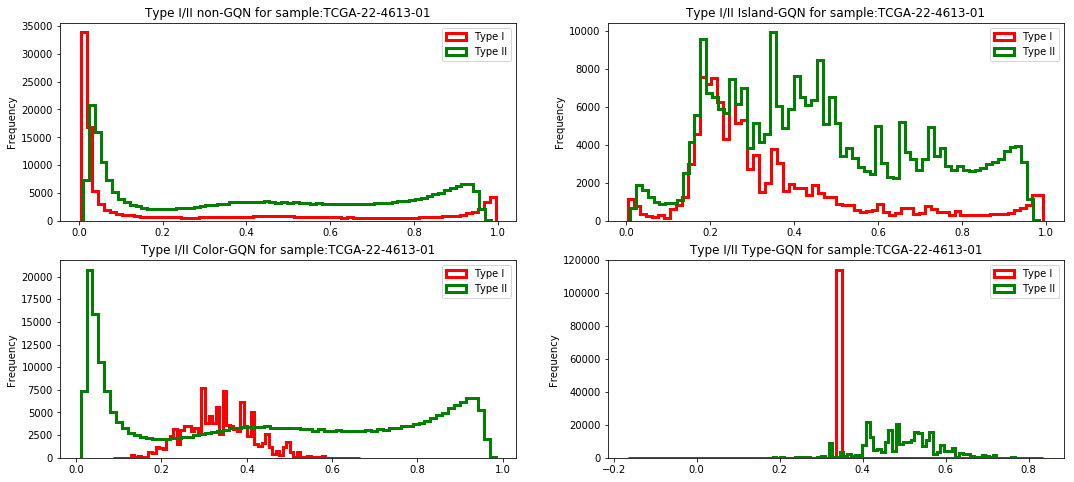

In [83]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,8))
_pat = 'TCGA-86-8278-01' # TCGA-22-4613-01, TCGA-86-8278-01, TCGA-44-4112-01

methylation[methylation.Infinium_Design_Type=='I'][_pat].plot.hist(bins=70, histtype='step', 
                                                    color='red', lw=3, label='Type I', ax=ax[0,0])
methylation[methylation.Infinium_Design_Type=='II'][_pat].plot.hist(bins=70, histtype='step', 
                                                    color='green', lw=3, label='Type II', ax=ax[0,0])

ax[0,0].legend()
ax[0,0].set_title('Type I/II non-GQN for sample:{}'.format(_pat))

methylation_GQN_Island[methylation_GQN_Island.Infinium_Design_Type=='I']\
                [_pat].plot.hist(bins=70, histtype='step', color='red', lw=3,label='Type I', ax=ax[0,1])

methylation_GQN_Island[methylation_GQN_Island.Infinium_Design_Type=='II']\
                [_pat].plot.hist(bins=70, histtype='step', color='green', lw=3,label='Type II', ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title('Type I/II Island-GQN for sample:{}'.format(_pat))


methylation_GQN_Color[methylation_GQN_Color.Infinium_Design_Type=='I']\
                [_pat].plot.hist(bins=70, histtype='step', color='red', lw=3,label='Type I', ax=ax[1,0])

methylation_GQN_Color[methylation_GQN_Color.Infinium_Design_Type=='II']\
                [_pat].plot.hist(bins=70, histtype='step', color='green', lw=3,label='Type II', ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title('Type I/II Color-GQN for sample:{}'.format(_pat))


methylation_GQN_Type[methylation_GQN_Type.Infinium_Design_Type=='I']\
                [_pat].plot.hist(bins=70, histtype='step', color='red', lw=3,label='Type I', ax=ax[1,1])

methylation_GQN_Type[methylation_GQN_Type.Infinium_Design_Type=='II']\
                [_pat].plot.hist(bins=70, histtype='step', color='green', lw=3,label='Type II', ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title('Type I/II Type-GQN for sample:{}'.format(_pat))



In [218]:
del methylation_globalQN
gc.collect()

34389

In [32]:
# CLEAN MEMORY
#del methylation
#gc.collect()

14

In [33]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

In [114]:
for _key in dict_methylation.keys():
    dict_methylation[_key] = dict_methylation[_key].copy().merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)
    gene_columns = [_col for _col in dict_methylation[_key].columns if 'GenX' in _col]
    other_columns = [_col for _col in dict_methylation[_key].columns if 'GenX' not in _col]

    dict_methylation[_key]['patient_nr'] = dict_methylation[_key].index
    tmp_min = dict_methylation[_key][['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
    dict_methylation[_key] = dict_methylation[_key].copy()[other_columns].merge(tmp_min, 
                                                                                how='right',
                                                                                left_index=True, 
                                                                                right_on='patient_nr')
    dict_methylation[_key] = dict_methylation[_key].loc[~dict_methylation[_key].index.duplicated(keep='first')]

# Bias correction functions
## L/S, cohort-based normalisation

Mean-based $$\mathbf{x}^*=\frac{\mathbf{x}-\overline{\mathbf{x}}}{\sigma}$$


Median-based $$\mathbf{x}^*=\frac{\mathbf{x}-median(\mathbf{x})}{IQR}$$






In [69]:
for _key in dict_methylation:
    df = dict_methylation[_key]
    gene_columns = [_col for _col in df.columns if 'GenX' in _col] 
    na_cols = df.loc[df.batch_number=='119.75.0', gene_columns].isnull().any(axis=0).sum()
    avg_na_per_col = df.loc[df.batch_number=='119.75.0', gene_columns].isna().sum().sum()/na_cols
    tot_cols = len(gene_columns)

    print("For {}; there are {} columns out of {} cols with an average of {} rows with NA's \n".format(_key, na_cols, tot_cols, avg_na_per_col))

For Methylation_Strand_plus_CpG_Island; there are 1410 columns out of 41370 cols with an average of 3.4695035460992907 rows with NA's 

For Methylation_Strand_plus_CpG_Nshelf; there are 220 columns out of 6339 cols with an average of 2.359090909090909 rows with NA's 

For Methylation_Strand_plus_CpG_Nshore; there are 675 columns out of 16866 cols with an average of 3.677037037037037 rows with NA's 

For Methylation_Strand_plus_CpG_Sshelf; there are 216 columns out of 5466 cols with an average of 3.4305555555555554 rows with NA's 

For Methylation_Strand_plus_CpG_Sshore; there are 512 columns out of 12790 cols with an average of 3.2265625 rows with NA's 

For Methylation_Strand_plus_CpG_NaN; there are 4280 columns out of 113592 cols with an average of 3.052803738317757 rows with NA's 

For Methylation_Strand_min_CpG_Island; there are 1380 columns out of 41794 cols with an average of 3.4521739130434783 rows with NA's 

For Methylation_Strand_min_CpG_Nshelf; there are 219 columns out of 5

We decide to simply impute the NaN's using the median.

In [76]:
# L/S correction
dict_methylation_prepped = {}
back_shift = True
for _key in tqdm(dict_methylation.keys()):
    dict_methylation_prepped[_key] = _preprocess(dict_methylation[_key], 
                                         col_range=None, 
                                         bias_removal=True, 
                                         debug=False, 
                                         scaler='standard', 
                                         imputer='median')
    if back_shift:
        # median shift back the data.. 
        gene_columns = [_col for _col in dict_methylation_prepped[_key].columns if 'GenX' in _col]    
        dict_methylation_prepped[_key].loc[:, gene_columns] *= dict_methylation[_key].loc[:, gene_columns].std(axis=0)
        dict_methylation_prepped[_key].loc[:, gene_columns] += dict_methylation[_key].loc[:, gene_columns].median(axis=0)


  0%|          | 0/12 [00:00<?, ?it/s]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (41366, 11), indices imply (41370, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


  8%|▊         | 1/12 [09:29<1:44:23, 569.38s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 17%|█▋        | 2/12 [11:02<55:14, 331.44s/it]  

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 25%|██▌       | 3/12 [15:08<45:24, 302.76s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 33%|███▎      | 4/12 [16:28<32:57, 247.23s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 42%|████▏     | 5/12 [19:36<27:26, 235.25s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (113577, 11), indices imply (113592, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-44


 50%|█████     | 6/12 [44:37<44:37, 446.25s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (41793, 11), indices imply (41794, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


 58%|█████▊    | 7/12 [54:25<38:52, 466.51s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (5945, 11), indices imply (5946, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417-0


 67%|██████▋   | 8/12 [55:51<27:55, 418.89s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 75%|███████▌  | 9/12 [59:51<19:57, 399.06s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 83%|████████▎ | 10/12 [1:01:17<12:15, 367.80s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (12903, 11), indices imply (12906, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


 92%|█████████▏| 11/12 [1:04:22<05:51, 351.15s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (114502, 11), indices imply (114514, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-44


100%|██████████| 12/12 [1:30:25<00:00, 452.13s/it]


Text(0.5,1,'Cohort comparison for GenX_MUC5B.chr11.1230961.1230963 (+ strand) with scaling')

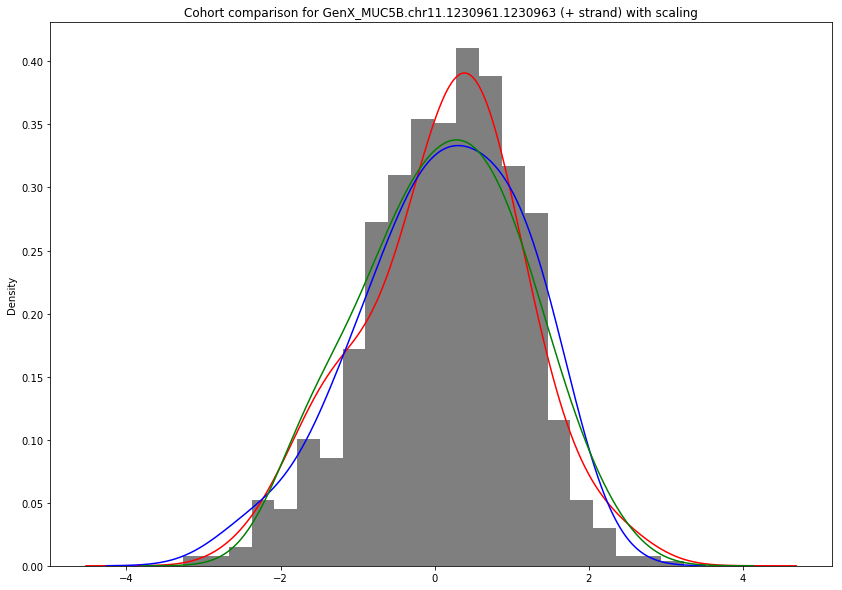

In [143]:
island='Methylation_Strand_min_CpG_Island'

test_gene = 'GenX_MUC5B.chr11.1230961.1230963'
dict_methylation_prepped[island][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black', density=True)
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='red')
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='blue')
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='green')
plt.title('Cohort comparison for {} (+ strand) with scaling'.format(test_gene))

Text(0.5,1,'Cohort comparison for GenX_MUC5B.chr11.1230961.1230963 (+ strand) without scaling')

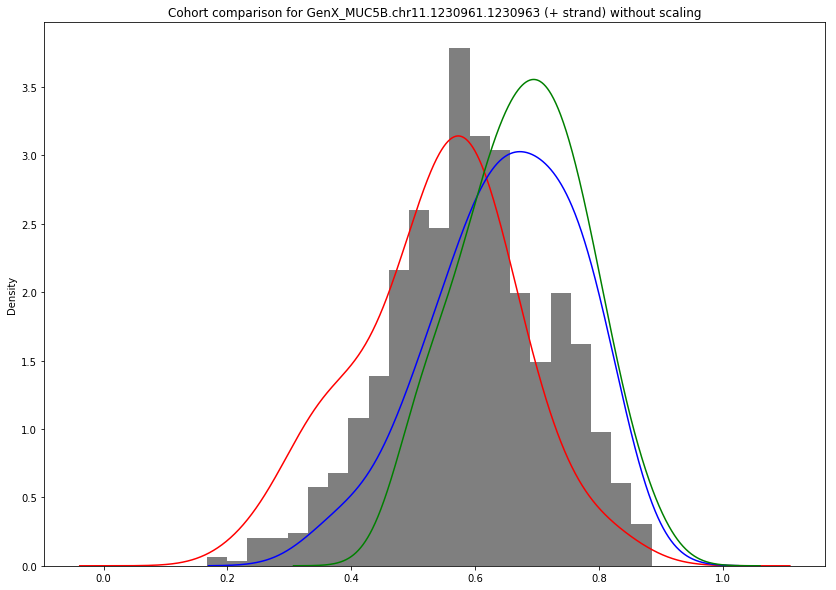

In [146]:
dict_methylation[island][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black', density=True)
dict_methylation[island].loc[dict_methylation[island].batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='red')
dict_methylation[island].loc[dict_methylation[island].batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='blue')
dict_methylation[island].loc[dict_methylation[island].batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='green')
plt.title('Cohort comparison for {} (+ strand) without scaling'.format(test_gene))

In [147]:
for _key in tqdm(dict_methylation_prepped):
    dict_methylation_prepped[_key].to_csv(sourceDir+"/Lung/_prepped/"+_key+".csv.gzip",
                                          compression="gzip")



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [02:53<31:49, 173.62s/it]

 17%|█▋        | 2/12 [03:17<16:27, 98.79s/it] 

 25%|██▌       | 3/12 [04:23<13:09, 87.76s/it]

 33%|███▎      | 4/12 [04:43<09:27, 70.99s/it]

 42%|████▏     | 5/12 [05:32<07:46, 66.59s/it]

 50%|█████     | 6/12 [14:00<14:00, 140.04s/it]

 58%|█████▊    | 7/12 [16:58<12:07, 145.49s/it]

 67%|██████▋   | 8/12 [17:25<08:42, 130.63s/it]

 75%|███████▌  | 9/12 [18:44<06:14, 124.91s/it]

 83%|████████▎ | 10/12 [19:11<03:50, 115.18s/it]

 92%|█████████▏| 11/12 [20:14<01:50, 110.38s/it]

100%|██████████| 12/12 [29:05<00:00, 145.46s/it]



# Cohort bias detection

a-priori and a-posteriori


In [39]:
import rpy2.robjects as robjects
import numpy as np
from rpy2.robjects.packages import importr
preprocessCore = importr('preprocessCore')


In [110]:
def _cohort_bias_detection(df, min_samples=10, n_comp=3):
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    cohorts = df.batch_number.unique().tolist()
    red_data_dict = {}
    for _cohort in tqdm(cohorts):
        ch = df['batch_number']==_cohort
        X = df.loc[ch, gene_columns]
        if X.shape[0]>min_samples:
            # PCA 3
            reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
            # put components in a dictionary with cohort as key
            X_red = reducer.fit_transform(X)
            #
            red_data_dict[_cohort] = {}
            red_data_dict[_cohort]['data'] = X_red
            red_data_dict[_cohort]['reducer'] = reducer
    
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    red_data_dict['ALL'] = 
    
    return red_data_dict

In [97]:
merged_RNA_min_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_plus_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_min_LS_median_PCA = _cohort_bias_detection(merged_RNA_min_CBC_LS)
merged_RNA_plus_LS_median_PCA = _cohort_bias_detection(merged_RNA_plus_CBC_LS)

100%|██████████| 43/43 [00:03<00:00, 13.00it/s]


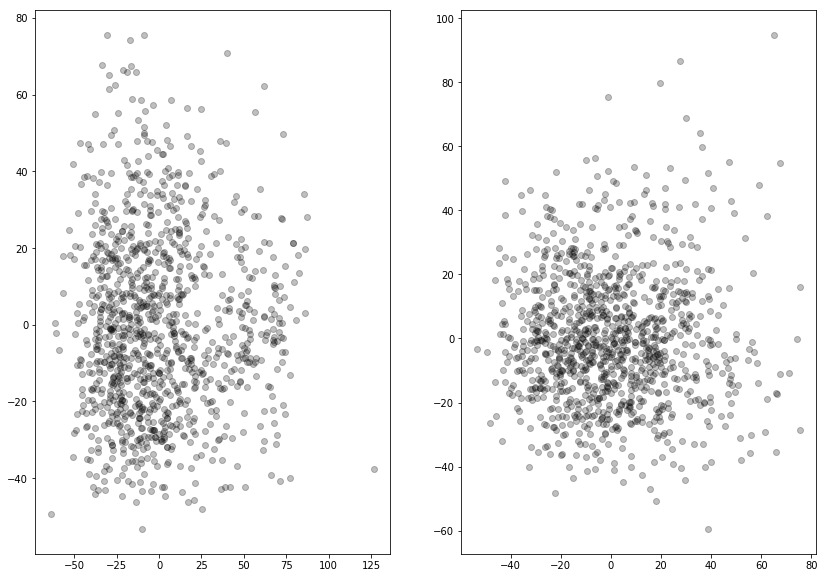

In [109]:
res_dict = merged_RNA_min_PCA

cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for _cohort in cohorts:
    ax[0].plot(res_dict[_cohort]['data'][:,0], 
             res_dict[_cohort]['data'][:,1], 'o', color='black', alpha=0.25)
    ax[1].plot(res_dict[_cohort]['data'][:,1], 
             res_dict[_cohort]['data'][:,2], 'o', color='black', alpha=0.25)    

    